# Resume Classification Project

**Business Objective**:

The goal of this project is to build an automated resume classification system that significantly reduces manual effort in Human Resource Management (HRM).
The system aims to improve screening efficiency by accurately classifying resumes into predefined job categories with minimal human intervention.

## 1. Project Setup & Initialization

### 1.1 Library Installation (One-Time Setup)

In [ ]:
# Install all required libraries
%pip install nltk spacy textract pandas seaborn matplotlib wordcloud scikit-learn python-docx

# Download required NLTK datasets
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

#cell should be executed only once to avoid redundancy

print("All libraries installed and NLTK data downloaded")


### 1.2 Import Libraries

In [1]:
import os
import re
import string
import textract
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pylab
from matplotlib import pyplot as plt
from docx import Document

# NLP Libraries
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer


### 1.3 Environment Configuration

In [2]:
#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir('../data/Resume_Docx/')

['Peoplesoft', 'React Developer', 'SQL Developer', 'workday']

## 2. Data Standardization (File Conversion)

Resumes are collected in multiple formats (PDF, DOC).
To ensure consistent processing, all resumes are standardized into DOCX format.

### 2.1 PDF to DOCX Conversion

In [ ]:
# DO NOT run this cell again, as it has already been executed. 
# PDF and DOC files have already been converted to DOCX format once. 
# Running this cell again will create duplicates and cause data inconsistency. 
# If this cell is run by mistake, replace 'Resume_Docx' with 'Unmodified_Resume_Docx' and rename unmodified to 'Resume_Docx' to avoid conflicts.

from pdf2docx import Converter

folder_path = r'D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\React Developer'

for file in os.listdir(folder_path):
    if file.lower().endswith('.pdf'):
        pdf_path = os.path.join(folder_path, file)
        docx_path = os.path.splitext(pdf_path)[0] + '.docx'

        try:
            cv = Converter(pdf_path)
            cv.convert(docx_path, start=0, end=None)
            cv.close()
            print(f"Converted: {file}")
        except Exception as e:
            print(f"Failed: {file} → {e}")


### 2.2 DOC to DOCX Conversion

In [ ]:
# DO NOT run this cell again, as it has already been executed. 
# PDF and DOC files have already been converted to DOCX format once. 
# Running this cell again will create duplicates and cause data inconsistency. 
# If this cell is run by mistake, replace 'Resume_Docx' with 'Unmodified_Resume_Docx' and rename unmodified to 'Resume_Docx' to avoid conflicts.

import os
import win32com.client as win32

# Initialize Word COM
word = win32.Dispatch("Word.Application")
word.Visible = False

# Base directory containing all folders
base_dir = r'D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx'

# List of folders you want to process
folders = ['Peoplesoft', 'React Developer', 'SQL Developer', 'workday']

for folder in folders:
    folder_path = os.path.abspath(os.path.join(base_dir, folder))
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    for file in os.listdir(folder_path):
        if file.lower().endswith(".doc") and not file.lower().endswith(".docx"):
            doc_path = os.path.join(folder_path, file)
            docx_path = doc_path + "x"  # Output file path

            if os.path.exists(doc_path):
                try:
                    doc = word.Documents.Open(doc_path)
                    doc.SaveAs(docx_path, FileFormat=16)  # 16 = docx
                    doc.Close()
                    print(f"Converted: {doc_path} → {docx_path}")
                except Exception as e:
                    print(f"Error converting {doc_path}: {e}")
            else:
                print(f"File not found: {doc_path}")

# Quit Word COM
word.Quit()


Converted: D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_G Ananda Rayudu.doc → D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_G Ananda Rayudu.docx
Converted: D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_Gangareddy.doc → D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_Gangareddy.docx
Converted: D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_Priyanka Ramadoss.doc → D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_Priyanka Ramadoss.docx
Converted: D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_srinivasarao.doc → D:\Data Science Excelr\Resume Classification Project\data\Resume_Docx\Peoplesoft\Peoplesoft Admin_srinivasarao.docx
Converted: D

## 3. Data Ingestion

This section focuses on loading resumes from standardized DOCX files and extracting meaningful text content.

### 3.1 Resume Text Extraction

#### 3.1.1 Text Extraction Function

In [4]:
# --- Function to extract text including tables ---
def extract_text_from_docx(file_path):
    doc = Document(file_path)
    full_text = []

    # Extract paragraphs
    for para in doc.paragraphs:
        if para.text.strip():
            full_text.append(para.text)

    # Extract tables (important for Technology sections)
    for table in doc.tables:
        for row in table.rows:
            row_text = " ".join(cell.text.strip() for cell in row.cells if cell.text.strip())
            if row_text:
                full_text.append(row_text)

    return ' '.join(full_text)

#### 3.1.2 Category-wise Resume Text Extraction

In [5]:
ps_text = []
ps_category = []
ps_dir = '../data/Resume_Docx/Peoplesoft'
for file in os.listdir(ps_dir):
    if file.lower().endswith(".docx"):
        path = os.path.join(ps_dir, file)
        text = extract_text_from_docx(path)
        ps_text.append(text)
        ps_category.append("Peoplesoft")


In [6]:
react_text = []
react_category = []
react_dir = '../data/Resume_Docx/React Developer'
for file in os.listdir(react_dir):
    if file.lower().endswith(".docx"):
        path = os.path.join(react_dir, file)
        text = extract_text_from_docx(path)
        react_text.append(text)
        react_category.append("React Developer")


In [7]:
sql_text = []
sql_category = []
sql_dir = '../data/Resume_Docx/SQL Developer'
for file in os.listdir(sql_dir):
    if file.lower().endswith(".docx"):
        path = os.path.join(sql_dir, file)
        text = extract_text_from_docx(path)
        ps_text.append(text)
        ps_category.append("SQL Developer")


In [8]:
workday_text = []
workday_category = []
workday_dir = '../data/Resume_Docx/workday'
for file in os.listdir(workday_dir):
    if file.lower().endswith(".docx"):
        path = os.path.join(workday_dir, file)
        text = extract_text_from_docx(path)
        ps_text.append(text)
        ps_category.append("workday")


#### 3.1.3 Resume Dataset Construction

In [9]:
df_ps = pd.DataFrame({'Raw_Text': ps_text, 'Category': ps_category})
df_react = pd.DataFrame({'Raw_Text': react_text, 'Category': react_category})
df_sql = pd.DataFrame({'Raw_Text': sql_text, 'Category': sql_category})
df_workday = pd.DataFrame({'Raw_Text': workday_text, 'Category': workday_category})


In [10]:
resume_data = pd.concat(
    [df_ps, df_react, df_sql, df_workday],
    axis=0
).reset_index(drop=True)

resume_data

,Raw_Text,Category
0,Anubhav Kumar Singh\t\t To work in a globa...,Peoplesoft
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,Peoplesoft
2,PeopleSoft Database Administrator Gangareddy ...,Peoplesoft
3,Murali Experience Summary I have 6 years of e...,Peoplesoft
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",Peoplesoft
...,...,...
74,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ Current...,React Developer
75,Name: M. Prabakaran \nTitle: UI Developer PROF...,React Developer
76,Pranish Sonone Career summary: Experience of 1...,React Developer
77,Ranga Gaganam Having 1+ years of successful ...,React Developer


In [11]:
from IPython.display import display, Markdown
display(Markdown(resume_data['Raw_Text'][3]))

Murali Experience Summary  I have 6 years of experience working in PeopleSoft Administration and performing various infrastructure related activities in PeopleSoft environments.  Installed and configured PeopleSoft 9.0,9.1,9.2 Web server, Application server, Database server and Process scheduler  server on Windows, UNIX and Linux platforms. Creating Domains for Web server, Application server and Process scheduler server. Applied Patches Manually and applied Maintenance Packs through Change Assistant tool. Experience in DPKs installations. Applying TAX UPDATES and fixes using PUM Migrating projects from one environment to another environment using Application Designer and also through CAPI, STAT tools. Performed Single sign on (SSO)Implementation. Experience in running Compare Reports between pre and Post Migrations. Experience in setting up Client Workstation for Developers and Testers. Involved in Configuration of Integration Broker setting up Between the Modules for sending the Messages. Involved 24/7 production Support to Client. Involved in Running Audit Reports (DDDAUDIT AND SYSAUDIT) for Integrity Checks. Experience in Configuration and Setup the REN server. Configured and Maintained Report Nodes settings. Checked and Clear Cache for the servers. Involved in Troubleshooting of the servers like Application server, web server and Process scheduler server.  Worked on Peopletools Upgrade PT8.52 to PT8.55 and 8.55 to 8.57. Installing and configuring Elastic Search 6.1.2 Career Profile: Client :Sembcorp , Brazil Description: This project involved active production support in the fields of HRMS 9.2. Additionally also involved in maintenance and enhancement of the system. Responsibility:  Installation and setup of People Soft HCM & ELM 9.2 on Oracle.  Creating database user, assigning roles & privileges to the users.  Maintaining various People Soft instances.  Debugging and resolving issues related to application server\web server\process    scheduler.  Weekly\monthly database maintains. Performed People tools upgrade from 8.55.14 to 8.57.05. Performing Post refresh Activities. Client :Wipro, IND Platforms : People Tools 8.56, People Soft HCM 9.2. Description: This project involved active production support in the fields of HRMS 9.2. Additionally also involved in maintenance and enhancement of the system. Responsibility:  Installation and setup of People Soft HCM 9.2 on Oracle.  Creating database user, assigning roles & privileges to the users.  Maintaining various People Soft instances.  Debugging and resolving issues related to application server\web server\process    scheduler.  Weekly\monthly database maintains.  Creating and modifying data mover scripts.  Migrating projects using CAPI.  Applying Patches.  Setting up a PeopleSoft Reporting environment for reporting.  Interacting with the client for various Production related issues. Applying TAX UPDATES using PUM. Performing Post refresh Activities.  Project Title :People Soft HCM Production Support and Enhancement Client : ASG, USA Platforms : People Tools 8.52,8.54 People Soft HCM 9.0,9.2 DB2 AIX 5.1. Description: This project involved active production support in the fields of HRMS 9.0. Additionally also involved in maintenance and enhancement of the system. Responsibility:  Installation and setup of People Soft HCM 9.0,9.1 on DB2.  Creating database user, assigning roles & privileges to the users.  Maintaining various People Soft instances.  Debugging and resolving issues related to application server\web server\process    scheduler.  Weekly\monthly database maintains.  Creating and modifying data mover scripts. Migrating projects using STAT,CAPI.  Applying Patches.  Setting up a PeopleSoft Reporting environment for reporting.  Interacting with the client for various Production related issues. Applying TAX UPDATES using PUM. Performing Post refresh Activities. Technology Personal Details Date: Place:  Hyderabad Dates Organization Role 22nd  Mar 2021 – 25th May 2021 L N T INFOTECH PeopleSoft Administrator Dates Organization Role 9th Nov 2018 –  19TH Mar 2021 Regency Technologies PeopleSoft Administrator Dates Organization Role 9th  Nov 2015 –  30th Nov 2017 DXC Technologies (Formerly known as CSC) PeopleSoft Administrator Operating Systems All Windows Platforms, Linux ERP and Tools PeopleSoft HRMS 9.0, PeopleTools 8.47,8.48, 8.50, 8.52, Putty, sql, TOAD, Beyond Compare. RDBMS Oracle 10g,11g Scheduling Tool Autosys Version Control Tool CAPI , STAT Languages C, C++, SQL Date of Birth 15-08-1982 Nationality Indian

In [12]:
# Analyze the distribution of resume categories in the dataset
resume_data['Category'].value_counts()

Category
React Developer    24
workday            21
Peoplesoft         20
SQL Developer      14
Name: count, dtype: int64

### 3.2 Save Raw Resume Text 

#### 3.2.1 Export to CSV

In [ ]:
# Execute save to CSV
resume_data.to_csv('..\data\Raw_Resume.csv', index=False)
# index=False: Don't save row indices
print("Data saved to Raw_Resume.csv")

#### 3.2.1.2 Verify File Creation

In [4]:
# Check file exists in directory
import os
if os.path.exists("..\data\Raw_Resume.csv"):
    file_size = os.path.getsize("..\data\Raw_Resume.csv")
    print(f"File created successfully!")
    print(f"File size: {file_size} bytes ({file_size/(1024*1024):.2f} MB)")
else:
    print("Error: File not created")

File created successfully!
File size: 415744 bytes (0.40 MB)


### 3.3 Reload Raw Resume 

In [14]:
resume_data = pd.read_csv("..\data\Raw_Resume.csv")
print("Raw Resume Text loaded successfully")

Raw Resume Text loaded successfully


In [15]:
resume_data.head()

,Raw_Text,Category
0,Anubhav Kumar Singh\t\t To work in a globa...,Peoplesoft
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,Peoplesoft
2,PeopleSoft Database Administrator Gangareddy ...,Peoplesoft
3,Murali Experience Summary I have 6 years of e...,Peoplesoft
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",Peoplesoft


In [16]:
resume_data[resume_data.Category == 'workday']

,Raw_Text,Category
34,Chinna Subbarayudu M DOB: 06th March 1994 Nati...,workday
35,Name : Gopi Krishna Reddy PROFESSIONAL...,workday
36,Hari Krishna M Summary: A result oriented prof...,workday
37,Harikrishna Akula ...,workday
38,HIMA.MENDU Career Objective To continue growin...,workday
39,...,workday
40,\t\t\t\t\t\t\tName:\tJ. Sumanth Royal. PROFESS...,workday
41,JYOTI VERMA\t\t\t\t\t 3 years of Experience in...,workday
42,\t\t\t\t\tMadeeswar A PROFILE SUMMARY: Having ...,workday
43,Mooraboyina Guravaiah Workday Integration Spec...,workday


In [17]:
# Count missing values per column
resume_data.isnull().sum()

Raw_Text    0
Category    0
dtype: int64

## 4. Exploratory Text Analysis

Initial analysis is performed to understand text length distribution, word counts, numerics and stopwords

### 4.1 Resume Length Analysis

In [18]:
resume_data['Word_Count'] = resume_data['Raw_Text'].fillna('').apply(lambda x: len(str(x).split()))
resume_data[['Raw_Text','Word_Count']].head()

,Raw_Text,Word_Count
0,Anubhav Kumar Singh\t\t To work in a globa...,963
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,987
2,PeopleSoft Database Administrator Gangareddy ...,786
3,Murali Experience Summary I have 6 years of e...,619
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",656


In [19]:
resume_data['Char_Count'] = resume_data['Raw_Text'].fillna('').str.len()
resume_data[['Raw_Text','Char_Count']].head()

,Raw_Text,Char_Count
0,Anubhav Kumar Singh\t\t To work in a globa...,7392
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,7932
2,PeopleSoft Database Administrator Gangareddy ...,6473
3,Murali Experience Summary I have 6 years of e...,4551
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",4949


### 4.2 Stopword and Numeric Distribution

In [20]:
from nltk.corpus import stopwords
print(stopwords.words('english')) 

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [21]:
stop = stopwords.words('english')
resume_data['Stopwords'] = resume_data['Raw_Text'].fillna('').apply(
    lambda x: len([w for w in re.findall(r'\b\w+\b', x.lower()) if w in stop])
)
resume_data[['Raw_Text','Stopwords']].head()

,Raw_Text,Stopwords
0,Anubhav Kumar Singh\t\t To work in a globa...,199
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,192
2,PeopleSoft Database Administrator Gangareddy ...,182
3,Murali Experience Summary I have 6 years of e...,122
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",138


In [22]:
resume_data['Numerics'] = resume_data['Raw_Text'].apply(
    lambda x: len(re.findall(r'\d+(?:\.\d+)?', x))
)
resume_data[['Raw_Text','Numerics']].head()

,Raw_Text,Numerics
0,Anubhav Kumar Singh\t\t To work in a globa...,60
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,77
2,PeopleSoft Database Administrator Gangareddy ...,61
3,Murali Experience Summary I have 6 years of e...,54
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",34


In [23]:
resume_data

,Raw_Text,Category,Word_Count,Char_Count,Stopwords,Numerics
0,Anubhav Kumar Singh\t\t To work in a globa...,Peoplesoft,963,7392,199,60
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,Peoplesoft,987,7932,192,77
2,PeopleSoft Database Administrator Gangareddy ...,Peoplesoft,786,6473,182,61
3,Murali Experience Summary I have 6 years of e...,Peoplesoft,619,4551,122,54
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",Peoplesoft,656,4949,138,34
...,...,...,...,...,...,...
74,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ Current...,React Developer,380,2988,81,12
75,Name: M. Prabakaran \nTitle: UI Developer PROF...,React Developer,420,2958,99,14
76,Pranish Sonone Career summary: Experience of 1...,React Developer,241,1637,52,22
77,Ranga Gaganam Having 1+ years of successful ...,React Developer,210,1600,58,3


In [24]:
resume_data.describe()

,Word_Count,Char_Count,Stopwords,Numerics
count,79.000000,79.000000,79.000000,79.000000
mean,707.911392,5227.088608,171.329114,27.000000
std,419.645124,3079.654735,108.976676,28.776326
min,200.000000,1600.000000,37.000000,3.000000
25%,415.500000,3307.000000,99.000000,12.000000
50%,602.000000,4340.000000,148.000000,15.000000
75%,896.000000,6552.000000,214.000000,23.500000
max,2512.000000,17991.000000,673.000000,151.000000


## 5. Text Preprocessing & Cleaning

This section transforms raw resume text into clean, structured, and model-ready data.

### 5.1 Resume Preprocessing Function

In [13]:
#!python -m spacy download en_core_web_sm

In [99]:
import re
import spacy
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from datetime import datetime

# ----------------------------
# Load SpaCy
# ----------------------------
nlp = spacy.load("en_core_web_sm")

tokenizer = RegexpTokenizer(r'[A-Za-z][A-Za-z0-9\+\#\.-]*')

# ----------------------------
# Regex patterns
# ----------------------------

TECH_PATTERN = re.compile(
    r"""
    (
        (html|css|v|ec|pt)  |
        c(\+\+|\#)        |
        [a-z]+[0-9]+      |
        [0-9]+[a-z]+      |
        [a-z]+[_-][a-z0-9]+ |
        [a-z]{3,}(?:[a-z0-9]+)?
    )
    """,
    re.X
)

FLUFF_PATTERN = re.compile(
    r"""
    ^(
        responsibility|responsibilities|
        professional|profile|summary|objective|
        organization|company|
        education|college|university|
        information|details|
        customer|client|user|
        service|services|
        work|experience|career|
        title|personal|dates|fields|also|additionally|various|active
    )s?$
    """,
    re.X
)

ACTION_VERB_PATTERN = re.compile(r'.*(ing|ed)$')

# ----------------------------
# Stopwords
# ----------------------------

generic_resume_words = [
    'date','birth','nationality','indian','place',
    'design','development','role','like','technology',
    'service','environment','experience','summary',
    'projects','project','team','teams','support',
    'skill','responsible','knowledge','tables','reports'
]

custom_stopwords = [
    'people','process','processes','tools','servers',
    'data','table','function','stored','business',
    'custom','report','integration','core','connector',
    'js','web','cs','good','worked','system',
    'team','workded','created','working','involved',
    'support','skill','skills','experience','project',
    'projects','handling','management','knowledge',
    'responsible','server','application','applications',
    'technologies','application server'
]

stop_words = list(
    set(stopwords.words('english'))
    .union(generic_resume_words)
    .union(custom_stopwords)
)

# ----------------------------
# Resume Cleaning Function
# ----------------------------

def preprocess_resume(text):

    if not text:
        return ""

    text = str(text)

    text = text.replace("\\", " ")
    text = re.sub(r'/', ' ', text)
    text = re.sub(r'(?<=\w)[-](?=\w)', '_', text)
    text = re.sub(r'[\)\}\]\(\[\:;,"\'`~!@\$%\^&\*\=<>\?]', ' ', text)

    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', ' ', text, flags=re.I)
    text = re.sub(r'\b(19|20)\d{2}\b', ' ', text)

    text = re.sub(
        r'\b(jan|january|feb|february|mar|march|apr|april|may|jun|june|'
        r'jul|july|aug|august|sep|sept|september|oct|october|nov|november|dec|december)\b',
        ' ',
        text,
        flags=re.I
    )

    text = re.sub(r'(?<![a-zA-Z])\d+\.\d+(?![a-zA-Z])', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\b([a-zA-Z]+)[0-9].*?\b', r'\1', text)

    doc = nlp(text)
    clean_tokens = []

    for token in doc:

        t = token.text.lower().strip(".-_")

        if not t:
            continue

        if token.pos_ in {"PRON", "DET", "CCONJ", "SCONJ", "PART", "INTJ"}:
            continue

        if token.ent_type_ in {"DATE", "TIME", "CARDINAL", "QUANTITY", "PERCENT"}:
            continue

        if token.ent_type_ in {"GPE", "LOC", "FAC", "NORP"}:
            continue

        if t in stop_words:
            continue

        if re.fullmatch(r'\d+', t) or re.fullmatch(r'\d+\.\d+', t):
            continue

        if len(t) == 1 and t != 'c':
            continue

        if FLUFF_PATTERN.match(t):
            continue

        if ACTION_VERB_PATTERN.match(t):
            continue

        if TECH_PATTERN.fullmatch(t):
            clean_tokens.append(t)

    return " ".join(clean_tokens)

# ----------------------------
# Experience Extraction
# ----------------------------

import re
from datetime import datetime

def calculate_experience(text):

    text = str(text)

    # -----------------------------------------
    # Direct Years Mention (8 years, 8+ years, 2.5 years)
    # -----------------------------------------
    year_match = re.search(
        r'(\d+(?:\.\d+)?)\s*(\+)?\s*(years?|yrs?)',
        text,
        re.I
    )

    if year_match:
        number = year_match.group(1)
        plus = "+" if year_match.group(2) else ""
        return f"{number}{plus} years"

    # -----------------------------------------
    # Direct Months Mention (9 months)
    # -----------------------------------------
    month_match = re.search(
        r'(\d+)\s*(months?|mos?)',
        text,
        re.I
    )

    if month_match:
        return f"{month_match.group(1)} months"

    # -----------------------------------------
    # Date Range Calculation (MM/YYYY - MM/YYYY or Current)
    # -----------------------------------------
    date_ranges = re.findall(
        r'(\d{2}/\d{4})\s*-\s*(current|present|\d{2}/\d{4})',
        text,
        re.I
    )

    total_months = 0
    now = datetime.now()

    for start_str, end_str in date_ranges:
        try:
            start_date = datetime.strptime(start_str, "%m/%Y")

            if end_str.lower() in ["current", "present"]:
                end_date = now
            else:
                end_date = datetime.strptime(end_str, "%m/%Y")

            months = (end_date.year - start_date.year) * 12 + \
                     (end_date.month - start_date.month)

            if months > 0:
                total_months += months

        except:
            continue

    if total_months > 0:
        years = total_months // 12
        months = total_months % 12

        if years > 0:
            return f"{years} years"
        else:
            return f"{months} months"

    return "Not Found"


# ----------------------------
# Skills Extraction
# ----------------------------

skills_list = [

    # =========================
    # Programming Languages
    # =========================
    "java","c","c++","c#","python","javascript","typescript","shell scripting","powershell",

    # =========================
    # Frontend
    # =========================
    "html","html5","css","css3","bootstrap","react","redux","angular","jquery","material ui",
    "next js","vue","axios","npm",

    # =========================
    # Backend
    # =========================
    "node js","express js",

    # =========================
    # Databases
    # =========================
    "sql","mysql","postgresql","oracle","oracle 10g","oracle 11g","oracle 12c","db2",
    "pl sql","pl/sql","toad","sql developer","oracle apps","r12"

    # =========================
    # PeopleSoft
    # =========================
    "peoplesoft","peoplesoft hrms","peoplesoft fscm","peopletools","application designer","application engine","component interface","integration broker","process scheduler","sqr","cobol","change assistant",
    "file layout","ae","ci","ps query","peoplesoft security","row level security","application package",
    "app engine","peoplecode","nvision","data mover","pia", "ib",                       

    # =========================
    # Workday
    # =========================
    "workday","workday hcm","workday fscm","workday studio","workday integrations","eib","core hcm",
    "calculated fields","report writer", "workday reports","birt","peci","ccw","workday prism","tenant setup"

    # =========================
    # Integration / APIs
    # =========================
    "rest api","rest apis","soap","web services","xml","xslt","json",

    # =========================
    # DevOps / CI-CD
    # =========================
    "git","github","jenkins","ansible","docker","kubernetes","ci cd","bitbucket","maven","gradle","jira","confluence"

    # =========================
    # Middleware / Servers
    # =========================
    "weblogic","tuxedo","apache",

    # =========================
    # Operating Systems
    # =========================
    "linux","unix","windows","aix","oel",

    # =========================
    # Tools / Utilities
    # =========================
    "winscp","filezilla","pcomm","tws","service now","ms office",

    # =========================
    # Cloud
    # =========================
    "aws","ec2","s3","azure","gcp"
]

def extract_skills(text):

    text = text.lower()
    found_skills = []

    for skill in skills_list:
        pattern = r'\b' + re.escape(skill) + r'\b'
        if re.search(pattern, text):
            found_skills.append(skill)

    return sorted(list(set(found_skills)))


### 5.2 Cleaned Resume Dataset Creation

In [100]:
# Load dataset
resume_data = pd.read_csv("..\data\Raw_Resume.csv")

resume_data["Resume_Details"] = resume_data["Raw_Text"].apply(preprocess_resume)
resume_data["experience_years"] = resume_data["Raw_Text"].apply(calculate_experience)
resume_data["skills"] = resume_data["Raw_Text"].apply(extract_skills)
resume_data.head()


,Raw_Text,Category,Resume_Details,experience_years,skills
0,Anubhav Kumar Singh\t\t To work in a globa...,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"[ansible, aws, change assistant, docker, githu..."
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,Peoplesoft,peoplesoft database administration human capit...,7+ years,"[application designer, aws, change assistant, ..."
2,PeopleSoft Database Administrator Gangareddy ...,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"[ae, app engine, db2, oel, oracle, oracle 10g,..."
3,Murali Experience Summary I have 6 years of e...,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"[aix, application designer, c, change assistan..."
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"[apache, application designer, aws, c, change ..."


In [101]:
display(Markdown(resume_data['Resume_Details'][3]))

murali peoplesoft administration infrastructure activities peoplesoft environments peoplesoft database scheduler platforms domains scheduler patches manually maintenance packs change assistant tool dpks installations tax updates fixes pum designer capi stat single sign sso implementation compare pre post migrations workstation developers testers configuration broker modules messages production audit dddaudit sysaudit integrity checks setup ren nodes settings clear cache scheduler peopletools upgrade elastic search sembcorp description production hrms maintenance enhancement installation setup soft hcm elm oracle database roles privileges soft instances issues scheduler weekly database maintains upgrade post refresh activities wipro ind platforms soft hcm description production hrms maintenance enhancement installation setup soft hcm oracle database roles privileges soft instances issues scheduler weekly database maintains mover scripts capi patches peoplesoft production issues tax updates pum post refresh activities soft hcm production enhancement asg usa platforms soft hcm aix description production hrms maintenance enhancement installation setup soft hcm database roles privileges soft instances issues scheduler weekly database maintains mover scripts stat capi patches peoplesoft production issues tax updates pum post refresh activities hyderabad infotech peoplesoft administrator regency peoplesoft administrator dxc formerly known csc peoplesoft administrator systems windows platforms linux erp peoplesoft hrms peopletools putty sql toad beyond compare rdbms oracle tool autosys version control tool capi stat languages c++ sql

In [102]:
resume_data

,Raw_Text,Category,Resume_Details,experience_years,skills
0,Anubhav Kumar Singh\t\t To work in a globa...,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"[ansible, aws, change assistant, docker, githu..."
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t 7+ years ...,Peoplesoft,peoplesoft database administration human capit...,7+ years,"[application designer, aws, change assistant, ..."
2,PeopleSoft Database Administrator Gangareddy ...,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"[ae, app engine, db2, oel, oracle, oracle 10g,..."
3,Murali Experience Summary I have 6 years of e...,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"[aix, application designer, c, change assistan..."
4,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"[apache, application designer, aws, c, change ..."
...,...,...,...,...,...
74,MD KHIZARUDDIN RAUF \t EXPERIENCE ⇨ Current...,React Developer,khizaruddin rauf currently pickupbiz solution ...,9 months,"[bootstrap, css, html, javascript, mysql, node..."
75,Name: M. Prabakaran \nTitle: UI Developer PROF...,React Developer,name prabakaran developer years software devel...,2.4+ years,"[aws, bitbucket, css, html, java, react, s3, u..."
76,Pranish Sonone Career summary: Experience of 1...,React Developer,sonone react developer includes hands pages re...,1 years,"[css, css3, html5, javascript, material ui, re..."
77,Ranga Gaganam Having 1+ years of successful ...,React Developer,ranga gaganam successful phases software life ...,1+ years,"[css3, html, html5, javascript, react]"


In [103]:
# Remove the Raw_Text column 
resume_data.drop(['Raw_Text'], axis = 1, inplace = True)
resume_data

,Category,Resume_Details,experience_years,skills
0,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"[ansible, aws, change assistant, docker, githu..."
1,Peoplesoft,peoplesoft database administration human capit...,7+ years,"[application designer, aws, change assistant, ..."
2,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"[ae, app engine, db2, oel, oracle, oracle 10g,..."
3,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"[aix, application designer, c, change assistan..."
4,Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"[apache, application designer, aws, c, change ..."
...,...,...,...,...
74,React Developer,khizaruddin rauf currently pickupbiz solution ...,9 months,"[bootstrap, css, html, javascript, mysql, node..."
75,React Developer,name prabakaran developer years software devel...,2.4+ years,"[aws, bitbucket, css, html, java, react, s3, u..."
76,React Developer,sonone react developer includes hands pages re...,1 years,"[css, css3, html5, javascript, material ui, re..."
77,React Developer,ranga gaganam successful phases software life ...,1+ years,"[css3, html, html5, javascript, react]"


In [104]:
# Check data types and missing values
print("\nData Info:")
print("="*60)
print(f"Missing values: {resume_data.isna().sum().sum()}")


Data Info:
Missing values: 0


In [105]:
# find duplicate rows
duplicates = resume_data[resume_data.duplicated(subset="Resume_Details", keep=False)]
display(duplicates)

,Category,Resume_Details,experience_years,skills
66,React Developer,ui_developer react developer name krishna exte...,3.2 years,"[bootstrap, css, css3, git, github, html, html..."
67,React Developer,ui_developer react developer name krishna exte...,3.2 years,"[bootstrap, css, css3, git, github, html, html..."
72,React Developer,mareedu lokesh babu overview around years soft...,2 years,"[apache, bootstrap, css, git, html, javascript..."
73,React Developer,mareedu lokesh babu overview around years soft...,2 years,"[apache, bootstrap, css, git, html, javascript..."


In [106]:
resume_data = resume_data.drop_duplicates(subset="Resume_Details")

In [107]:
# find duplicate rows
duplicates = resume_data[resume_data.duplicated(subset="Resume_Details", keep=False)]
display(duplicates)

,Category,Resume_Details,experience_years,skills


### 5.3 Save Cleaned Resume 

#### 5.3.1 Export to CSV

In [108]:
# Execute save to CSV
resume_data.to_csv('..\data\Cleaned_Resumes.csv', index=False)
# index=False: Don't save row indices
print("Data saved to Cleaned_Resumes.csv")

Data saved to Cleaned_Resumes.csv


#### 5.3.2 Verify File Creation

In [109]:
# Check file exists in directory
import os
if os.path.exists("..\data\Cleaned_Resumes.csv"):
    file_size = os.path.getsize("..\data\Cleaned_Resumes.csv")
    print(f"File created successfully!")
    print(f"File size: {file_size} bytes ({file_size/(1024*1024):.2f} MB)")
else:
    print("Error: File not created")

File created successfully!
File size: 200950 bytes (0.19 MB)


### 5.4 Reload Cleaned Resume 

In [110]:
# Load the cleaned resume dataset
resume_data = pd.read_csv('..\data\Cleaned_Resumes.csv')
resume_data.head()

,Category,Resume_Details,experience_years,skills
0,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"['ansible', 'aws', 'change assistant', 'docker..."
1,Peoplesoft,peoplesoft database administration human capit...,7+ years,"['application designer', 'aws', 'change assist..."
2,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"['ae', 'app engine', 'db2', 'oel', 'oracle', '..."
3,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"['aix', 'application designer', 'c', 'change a..."
4,Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"['apache', 'application designer', 'aws', 'c',..."


In [111]:
# Display a sample resume in Markdown format
display(Markdown(resume_data['Resume_Details'][3]))

murali peoplesoft administration infrastructure activities peoplesoft environments peoplesoft database scheduler platforms domains scheduler patches manually maintenance packs change assistant tool dpks installations tax updates fixes pum designer capi stat single sign sso implementation compare pre post migrations workstation developers testers configuration broker modules messages production audit dddaudit sysaudit integrity checks setup ren nodes settings clear cache scheduler peopletools upgrade elastic search sembcorp description production hrms maintenance enhancement installation setup soft hcm elm oracle database roles privileges soft instances issues scheduler weekly database maintains upgrade post refresh activities wipro ind platforms soft hcm description production hrms maintenance enhancement installation setup soft hcm oracle database roles privileges soft instances issues scheduler weekly database maintains mover scripts capi patches peoplesoft production issues tax updates pum post refresh activities soft hcm production enhancement asg usa platforms soft hcm aix description production hrms maintenance enhancement installation setup soft hcm database roles privileges soft instances issues scheduler weekly database maintains mover scripts stat capi patches peoplesoft production issues tax updates pum post refresh activities hyderabad infotech peoplesoft administrator regency peoplesoft administrator dxc formerly known csc peoplesoft administrator systems windows platforms linux erp peoplesoft hrms peopletools putty sql toad beyond compare rdbms oracle tool autosys version control tool capi stat languages c++ sql

In [112]:
# Basic dataset inspection
print("Dataset Shape:", resume_data.shape)
resume_data.info()

Dataset Shape: (77, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Category          77 non-null     object
 1   Resume_Details    77 non-null     object
 2   experience_years  77 non-null     object
 3   skills            77 non-null     object
dtypes: object(4)
memory usage: 2.5+ KB


In [113]:
# Check for missing values
resume_data.isnull().sum()

Category            0
Resume_Details      0
experience_years    0
skills              0
dtype: int64

In [114]:
# Analyze category distribution
resume_data['Category'].value_counts()

Category
React Developer    22
workday            21
Peoplesoft         20
SQL Developer      14
Name: count, dtype: int64

In this step 5, raw resume text is transformed into clean, normalized, and skill-focused data suitable for downstream analysis. An NLP pipeline is initialized using SpaCy’s English language model to enable tokenization, lemmatization, and part-of-speech tagging. Multiple rule-based and regex-based cleaning operations are applied to remove noise such as dates, years, URLs, email addresses, punctuation, special characters, numeric artifacts, and resume boilerplate content that do not contribute to job-role discrimination. Generic English stopwords and resume-specific action verbs are eliminated to reduce linguistic clutter and improve signal quality. Token-level filtering is then performed to retain only meaningful technical terms by leveraging part-of-speech constraints (primarily nouns and proper nouns) and custom regex patterns designed to preserve programming languages, frameworks, databases, and enterprise systems. All these preprocessing steps are encapsulated within a single reusable preprocessing function, which accepts raw resume text as input, applies the complete sequence of cleaning, normalization, and filtering operations, and outputs standardized, lemmatized, and domain-relevant text. This function is systematically applied across the entire resume dataset to generate a cleaned text representation, forming a high-quality and consistent input for keyword extraction and TF-IDF feature engineering in subsequent stages.

## 6. Exploratory Data Visualization

This section visually explores the cleaned dataset to identify trends and patterns.

### 6.1 Category Distribution Analysis

#### 6.1.1 Resume count per category

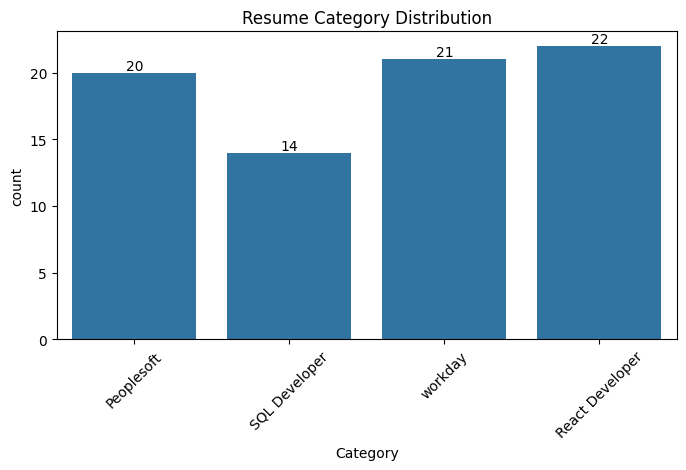

In [30]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='Category', data=resume_data)

# rotate x labels
plt.xticks(rotation=45)
plt.title("Resume Category Distribution")

# add count labels on top
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

#### Resume Category Percentage distribution

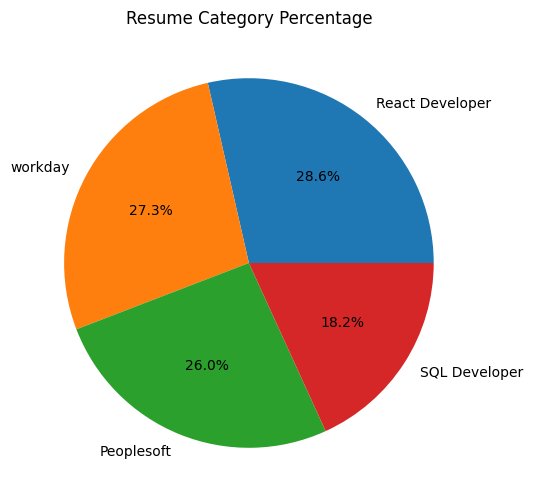

In [55]:
resume_data['Category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6,6)
)
plt.title("Resume Category Percentage")
plt.ylabel("")
plt.show()

### 6.2 Resume Length Comparison

In [56]:
resume_data['Resume_Length'] = resume_data['Resume_Details'].apply(len)

In [57]:
resume_data.head()

,Category,Resume_Details,experience_years,skills,Resume_Length
0,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"['unix', 'github', 'ansible', 'docker', 'windo...",3440
1,Peoplesoft,peoplesoft database administration human capit...,7+ years,"['unix', 'java', 'windows', 'fscm', 'c', 'orac...",3470
2,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"['unix', 'peoplesoft hrms', 'windows', 'fscm',...",2703
3,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"['unix', 'c++', 'peoplesoft hrms', 'windows', ...",1653
4,Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"['unix', 'windows', 'fscm', 'service now', 'c'...",2606


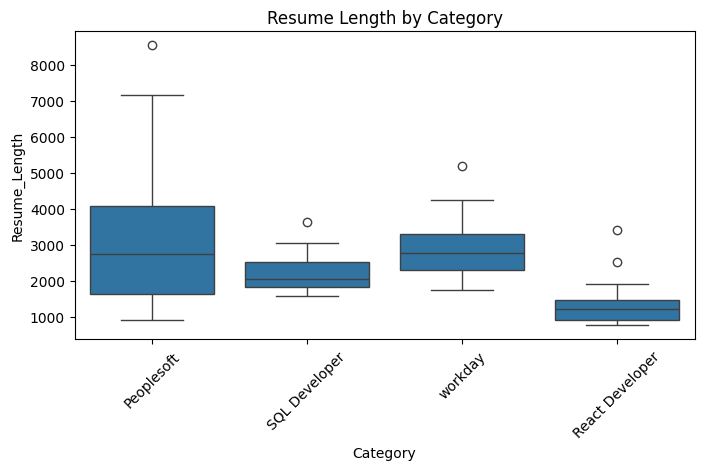

In [58]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Category', y='Resume_Length', data=resume_data)
plt.xticks(rotation=45)
plt.title("Resume Length by Category")
plt.show()

## 7. Keyword & N-gram Analysis

This section identifies the most frequent and meaningful terms across resumes

#### 7.1 Top Keywords per Category

#### 7.1.1.1 Function to Extract Top Words by Resume Category


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(category, n=10):
    text = resume_data[resume_data['Category'] == category]['Resume_Details']
    
    vectorizer = CountVectorizer(
        stop_words='english',
        max_features=n
    )
    X = vectorizer.fit_transform(text)
    
    return pd.DataFrame({
        'Word': vectorizer.get_feature_names_out(),
        'Frequency': X.toarray().sum(axis=0)
    }).sort_values(by='Frequency', ascending=False)


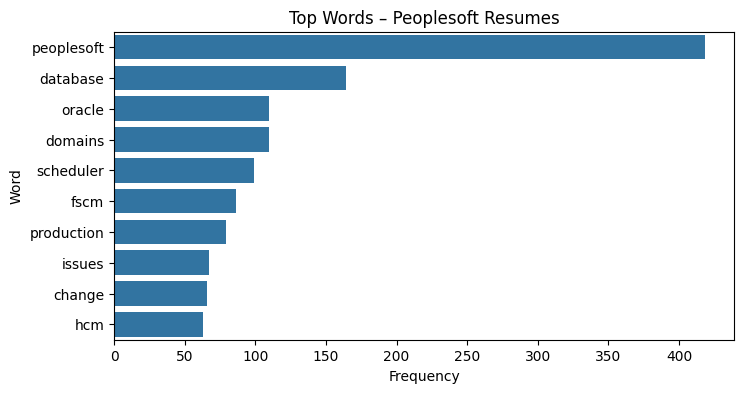

In [60]:
top_people = get_top_words('Peoplesoft', 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Word', data=top_people)
plt.title("Top Words – Peoplesoft Resumes")
plt.show()


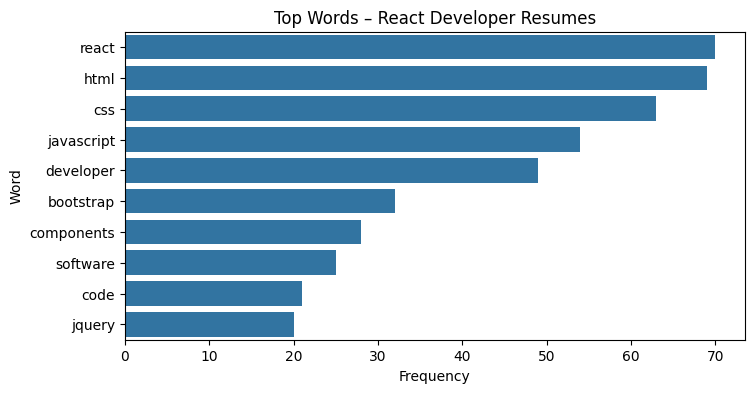

In [61]:
top_react = get_top_words('React Developer', 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Word', data=top_react)
plt.title("Top Words – React Developer Resumes")
plt.show()


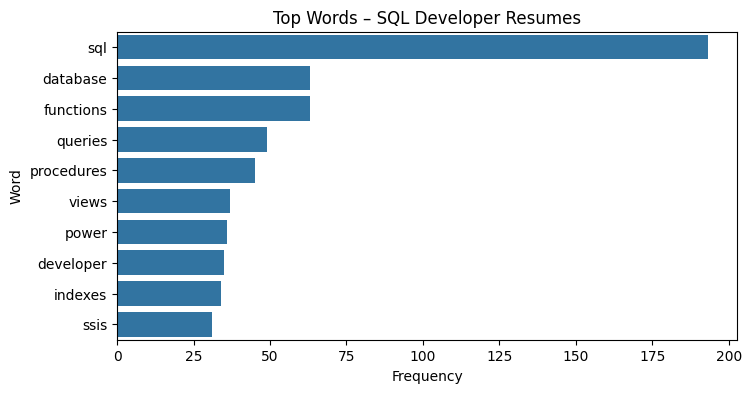

In [62]:
top_sql = get_top_words('SQL Developer', 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Word', data=top_sql)
plt.title("Top Words – SQL Developer Resumes")
plt.show()

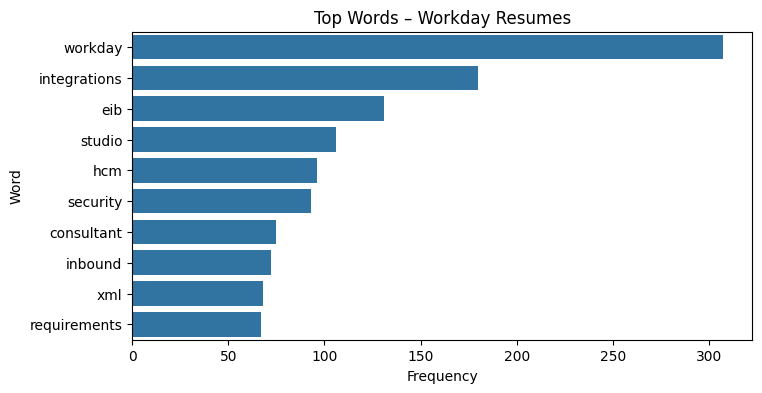

In [63]:
top_workday = get_top_words('workday', 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Word', data=top_workday)
plt.title("Top Words – Workday Resumes")
plt.show()


In [64]:
resume_data

,Category,Resume_Details,experience_years,skills,Resume_Length
0,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"['unix', 'github', 'ansible', 'docker', 'windo...",3440
1,Peoplesoft,peoplesoft database administration human capit...,7+ years,"['unix', 'java', 'windows', 'fscm', 'c', 'orac...",3470
2,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"['unix', 'peoplesoft hrms', 'windows', 'fscm',...",2703
3,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"['unix', 'c++', 'peoplesoft hrms', 'windows', ...",1653
4,Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"['unix', 'windows', 'fscm', 'service now', 'c'...",2606
...,...,...,...,...,...
72,React Developer,khizaruddin rauf currently pickupbiz solution ...,9 months,"['java', 'bootstrap', 'mysql', 'react', 'mongo...",1267
73,React Developer,name prabakaran developer years software devel...,2.4+ years,"['unix', 'java', 'react', 'windows', 'c', 'css...",1274
74,React Developer,sonone react developer includes hands pages re...,1 years,"['java', 'react', 'material ui', 'javascript',...",783
75,React Developer,ranga gaganam successful phases software life ...,1+ years,"['java', 'react', 'javascript', 'c', 'css', 'h...",787



### 7.2 WordCloud Visualization

In [65]:
### Global Word Frequency Analysis of Resume Text
from collections import Counter

all_words = " ".join(resume_data['Resume_Details']).split()
common_words = Counter(all_words).most_common(20)

common_words

[('peoplesoft', 448),
 ('workday', 307),
 ('database', 245),
 ('sql', 244),
 ('integrations', 180),
 ('hcm', 159),
 ('technical', 150),
 ('security', 134),
 ('production', 131),
 ('oracle', 131),
 ('eib', 131),
 ('issues', 130),
 ('studio', 123),
 ('developer', 116),
 ('domains', 115),
 ('requirements', 112),
 ('test', 109),
 ('new', 107),
 ('windows', 106),
 ('scheduler', 106)]

#### 7.2.1 WordCloud for Overall Resume Text


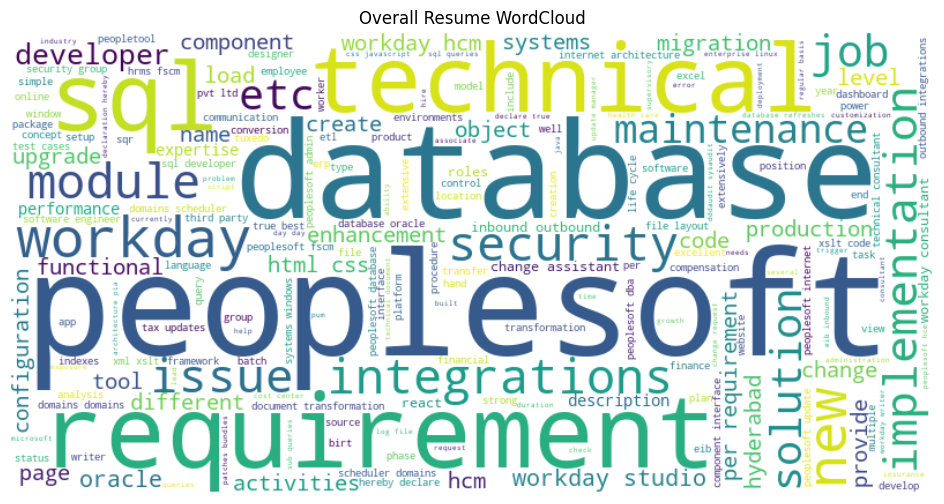

In [66]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk_stopwords = set(w.lower() for w in stopwords.words('english'))

all_text = " ".join(resume_data['Resume_Details'])  


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words
).generate(all_text)


plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Overall Resume WordCloud")
plt.axis('off')
plt.show()


#### 7.2.2 WordCloud Visualization by Job Category


In [67]:
### Function to Generate Category-wise WordCloud

def category_wordcloud(category_name):
    text = " ".join(
        resume_data[resume_data['Category'] == category_name]['Resume_Details']
    )
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=set(stopwords.words('english'))
    ).generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {category_name}")
    plt.show()

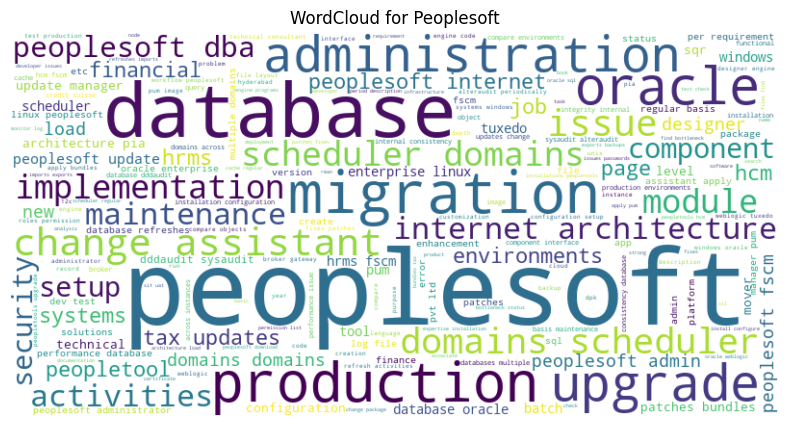

In [68]:
category_wordcloud("Peoplesoft")

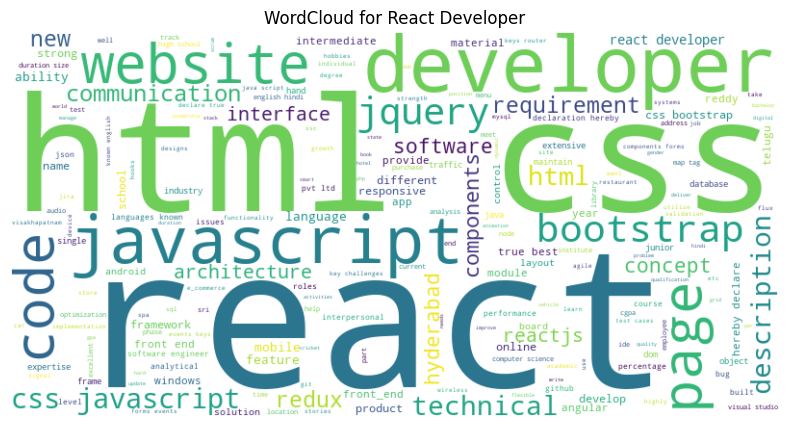

In [69]:
category_wordcloud("React Developer")

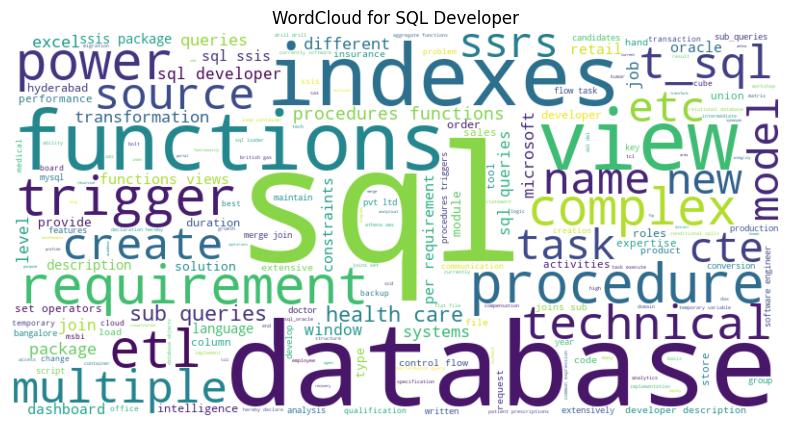

In [70]:
category_wordcloud("SQL Developer")

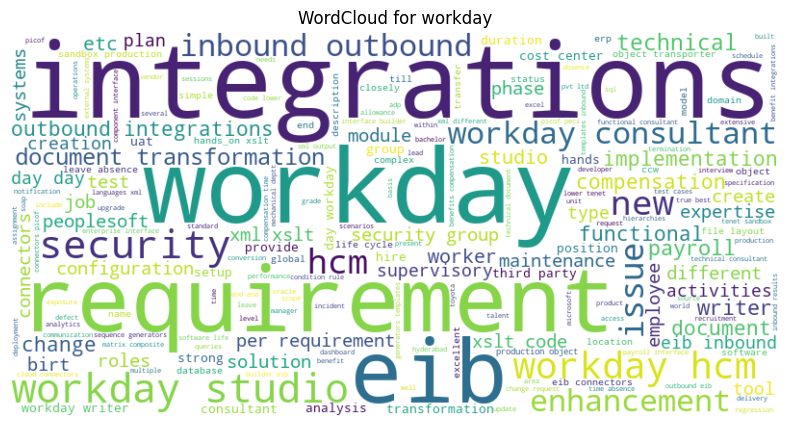

In [71]:
category_wordcloud("workday")

### 7.3 N-gram Analysis

Bi-grams and tri-grams are extracted from resume text to capture contextual skill patterns and commonly occurring word sequences.

In [72]:
### Function to Extract Top N-grams from Resume Text
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(
        stop_words='english',
        ngram_range=ngram_range,
        max_features=n
    )
    bag = vec.fit_transform(corpus)
    
    return pd.DataFrame({
        'Ngram': vec.get_feature_names_out(),
        'Frequency': bag.toarray().sum(axis=0)
    }).sort_values(by='Frequency', ascending=False)


#### 7.3.1 Bi-gram Frequency Analysis in Resumes


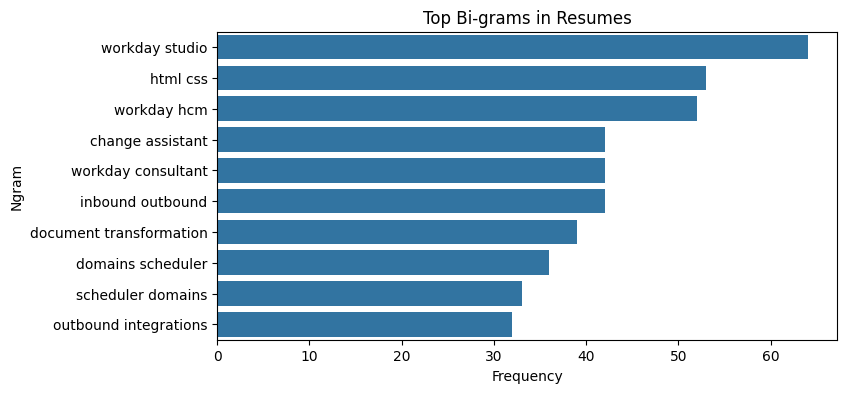

In [73]:
bigrams = get_top_ngrams(resume_data['Resume_Details'], (2,2), 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Ngram', data=bigrams)
plt.title("Top Bi-grams in Resumes")
plt.show()


In [74]:
#### 7.3.2 Tri-gram Frequency Analysis in Resumes


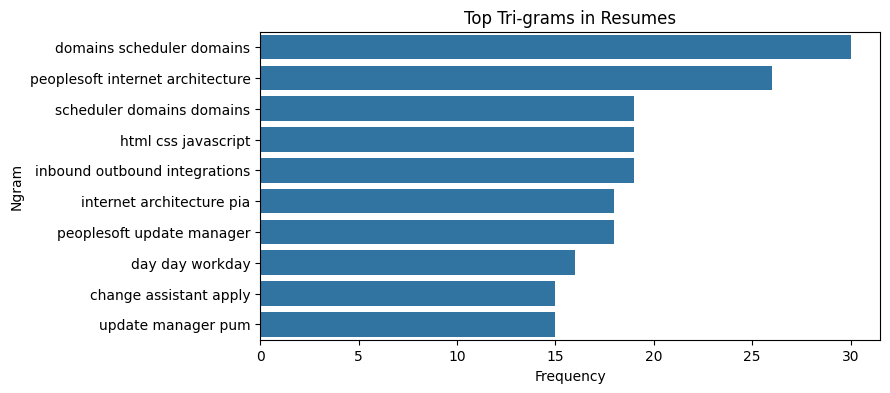

In [75]:
trigrams = get_top_ngrams(resume_data['Resume_Details'], (3,3), 10)

plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Ngram', data=trigrams)
plt.title("Top Tri-grams in Resumes")
plt.show()


## 8. TF-IDF Feature Engineering

This section focuses on identifying discriminative features in resumes using TF-IDF
(Term Frequency-Inverse Document Frequency) to highlight important words and n-grams

### 8.1 Category-wise TF-IDF Analysis

In [76]:
# Function to Compute Top TF-IDF Words by Category

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,           
    ngram_range=(1,3),
    min_df=10,                  
    max_df=0.8, 
)

# Fit on all resumes (entire corpus)
tfidf.fit(resume_data['Resume_Details'])


def top_tfidf_by_class(class_name, top_n=10):
    # Filter resumes of the given class
    class_docs = resume_data[resume_data['Category'] == class_name]['Resume_Details']
    
    # Transform text into TF-IDF vectors
    tfidf_matrix = tfidf.transform(class_docs)
    
    # Compute average TF-IDF score for each word
    mean_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get indices of top_n words sorted by descending importance
    top_indices = mean_scores.argsort()[::-1][:top_n]
    
    # Get the actual words
    top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]
    
    # Get their corresponding scores for clarity
    top_scores = [mean_scores[i] for i in top_indices]
    
    # Return as a DataFrame for better readability
    return pd.DataFrame({'Word': top_words, 'Mean_TFIDF': top_scores})

dfs = []
for cat in resume_data['Category'].unique():
    df = top_tfidf_by_class(cat, top_n=10)
    df.columns = [f"{col}_{cat}" for col in df.columns]  
    dfs.append(df)

# Concatenate side by side
result = pd.concat(dfs, axis=1)
display(result)


,Word_Peoplesoft,Mean_TFIDF_Peoplesoft,Word_SQL Developer,Mean_TFIDF_SQL Developer,Word_workday,Mean_TFIDF_workday,Word_React Developer,Mean_TFIDF_React Developer
0,peoplesoft,0.426093,sql,0.445273,workday,0.450674,react,0.243358
1,oracle,0.127810,functions,0.190795,integrations,0.263446,html,0.225915
2,fscm,0.124193,procedures,0.150989,eib,0.193716,css,0.210780
3,database,0.115741,database,0.147572,studio,0.125840,javascript,0.193520
4,domains,0.104341,views,0.122223,hcm,0.112100,html css,0.176190
5,scheduler,0.098462,queries,0.121251,security,0.103579,bootstrap,0.112654
6,production,0.080795,indexes,0.116154,inbound,0.102797,developer,0.101524
7,peopletools,0.075403,etl,0.110820,consultant,0.098207,css javascript,0.075121
8,designer,0.074518,triggers,0.109092,workday studio,0.097310,html css javascript,0.073156
9,patches,0.073009,joins,0.100219,xml,0.095151,components,0.067417


### 8.2 Visualizing Top TF-IDF Words by Category

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_words(class_name, top_n=10):
    df = top_tfidf_by_class(class_name, top_n)
    plt.figure(figsize=(8,4))
    sns.barplot(x='Mean_TFIDF', y='Word', data=df)
    plt.title(f"Top {top_n} TF-IDF Words for {class_name}")
    plt.show()

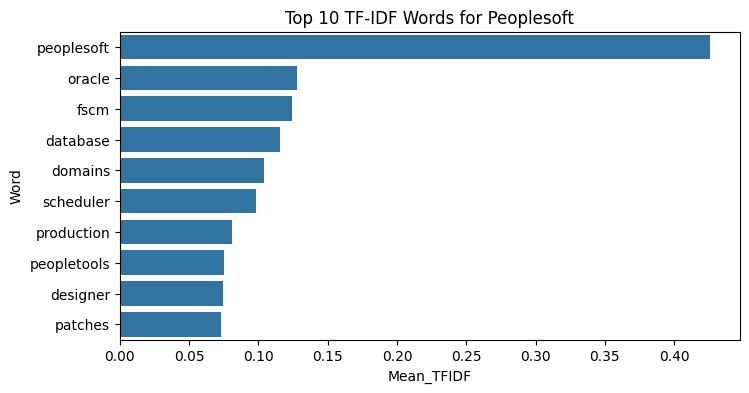

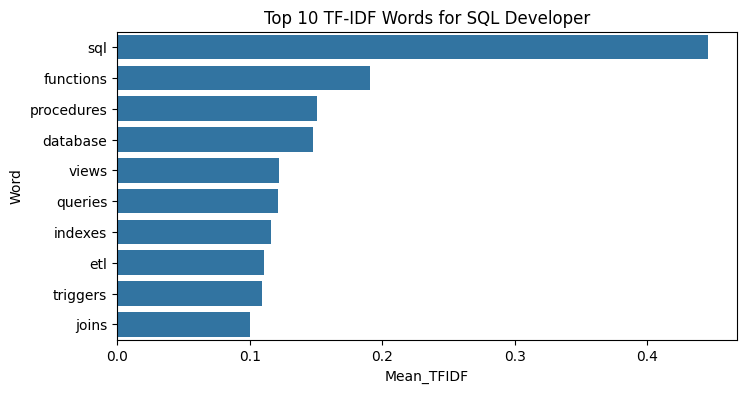

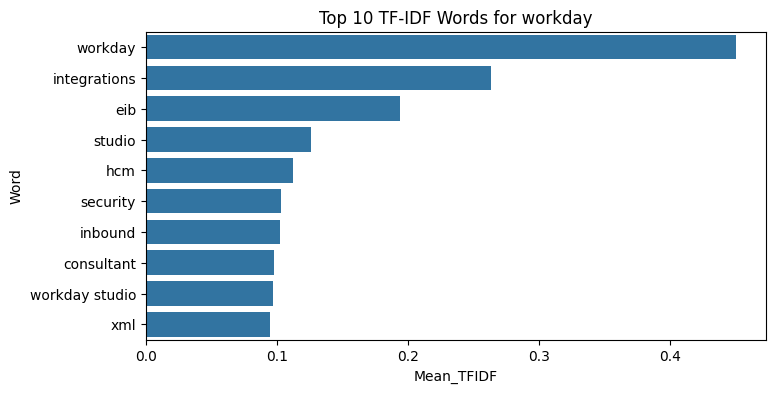

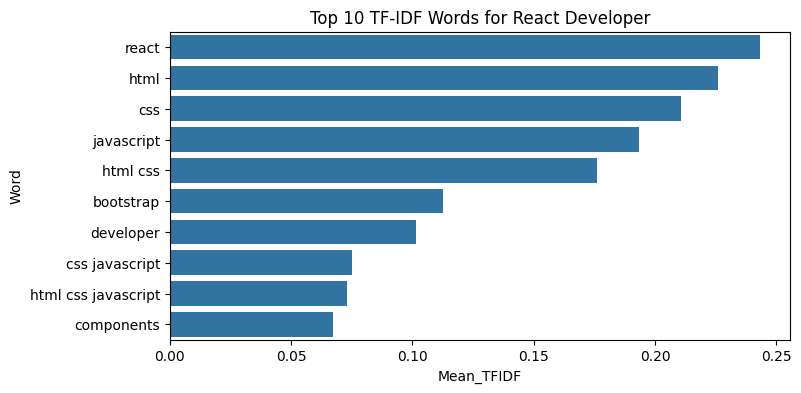

In [78]:
for col in list(resume_data['Category'].unique()):
    plot_top_words(col, top_n=10)

### 8.3 Top TF-IDF Words/N-grams Across All Resumes

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Fit TF-IDF on all resumes
tfidf_all = TfidfVectorizer(
    max_features=3000,           
    ngram_range=(1,3),
    min_df=10,                  
    max_df=0.8
)
tfidf_matrix_all = tfidf_all.fit_transform(resume_data['Resume_Details'])

# Get top 20 words overall
scores = np.asarray(tfidf_matrix_all.mean(axis=0)).flatten()
tokens = tfidf_all.get_feature_names_out()
top_indices = scores.argsort()[::-1][:20]

top_tfidf_df= pd.DataFrame({'Word': [tokens[i] for i in top_indices],
              'Mean_TFIDF': [scores[i] for i in top_indices]})


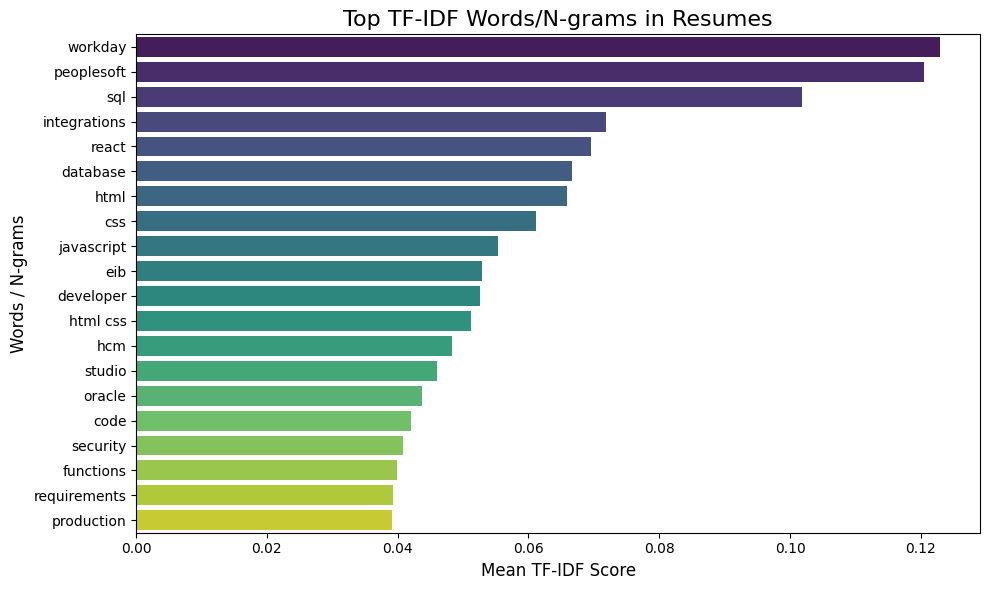

In [80]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Mean_TFIDF', y='Word', data=top_tfidf_df, palette='viridis')
plt.title("Top TF-IDF Words/N-grams in Resumes", fontsize=16)
plt.xlabel("Mean TF-IDF Score", fontsize=12)
plt.ylabel("Words / N-grams", fontsize=12)
plt.tight_layout()
plt.show()


### 8.5 WordCloud of Top TF-IDF Words Across All Resumes

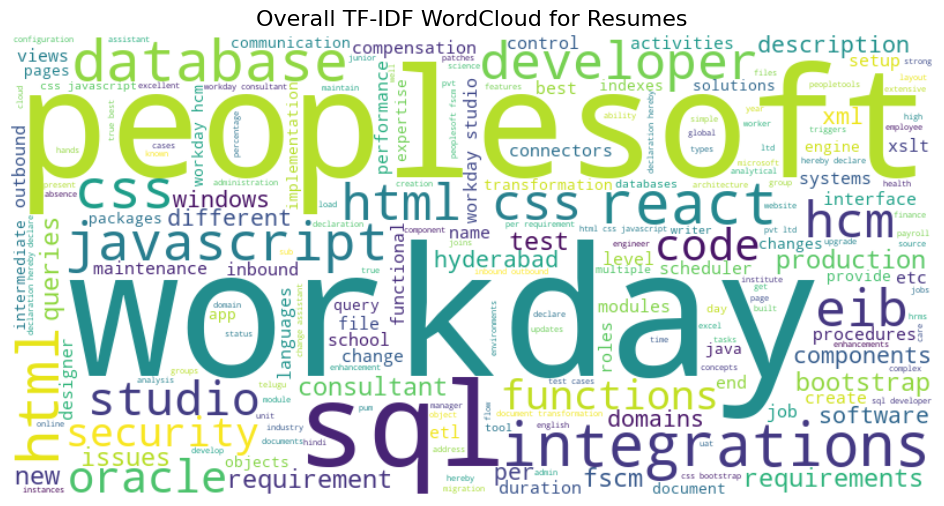

In [81]:
# Get words and their TF-IDF scores
tokens = tfidf_all.get_feature_names_out()
scores = np.asarray(tfidf_matrix_all.mean(axis=0)).flatten()
tfidf_dict = dict(zip(tokens, scores))

# Generate WordCloud weighted by TF-IDF scores
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(tfidf_dict)

# Plot the WordCloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall TF-IDF WordCloud for Resumes", fontsize=16)
plt.show()

### 8.4 WordCloud Visualization of Top TF-IDF Words by Category

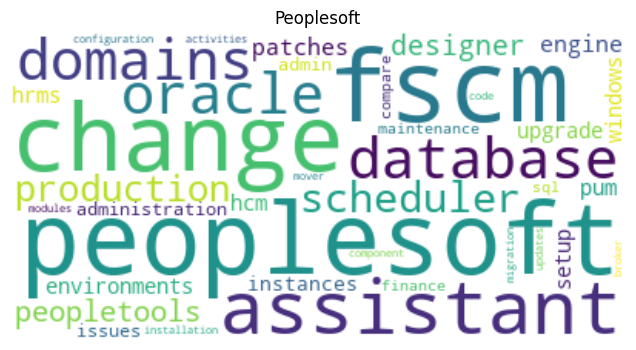

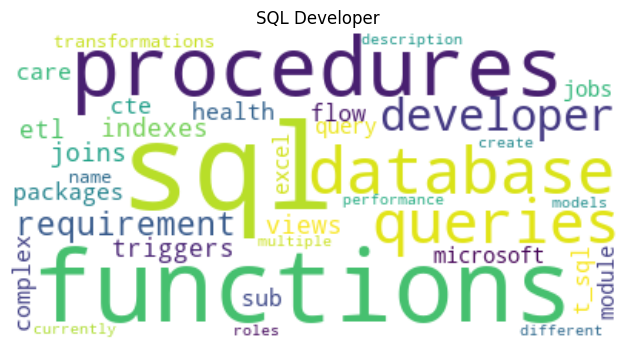

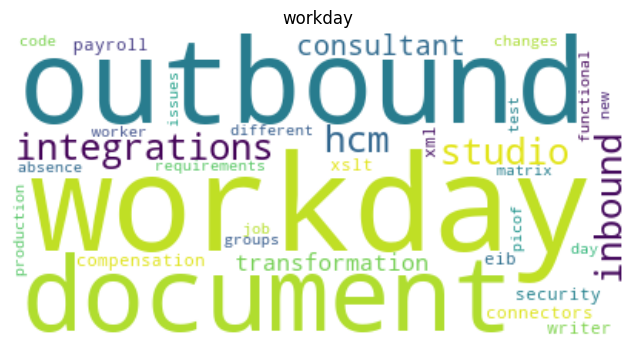

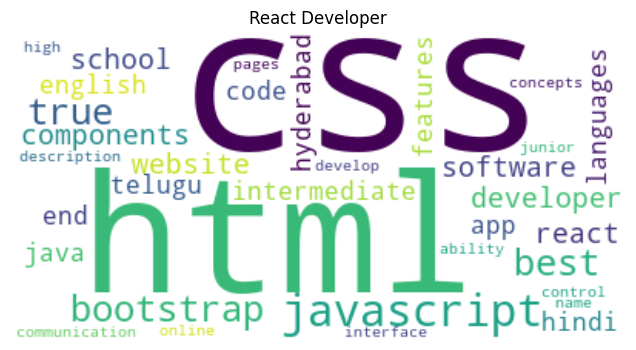

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cat in resume_data['Category'].unique():
    df = top_tfidf_by_class(cat, top_n=40)
    text = " ".join(df['Word'])  # assuming df has a 'Term' column
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(cat)
    plt.show()


## Analysis and Data Preprocessing Complete!

### Summary of Analysis and Feature Engineering

1. **Project Setup**  : Essential Python libraries for NLP, visualization, and feature engineering were installed and imported. The environment was configured to ensure smooth, reproducible execution.
2. **Data Standardization** : Resumes collected in multiple formats (PDF and DOC) were converted into a uniform DOCX format to enable consistent and reliable text extraction.
3. **Data Ingestion** : Resume text was extracted from DOCX files, including both paragraph content and tabular sections (commonly used for skills). Each resume was labeled by job category and consolidated into a structured dataset.
4. **Exploratory Text Analysis** : Basic statistical analysis such as resume length, word count, and noise distribution was conducted to understand text characteristics and guide preprocessing decisions.
5. **Text Preprocessing & Cleaning** : A reusable NLP preprocessing pipeline was applied to remove noise such as URLs, dates, stopwords, and irrelevant tokens, while preserving skill- and technology-related terms. This resulted in clean, normalized, model-ready resume text.
6. **Exploratory Data Visualization** : Visual analysis was performed on the cleaned dataset to understand category-wise patterns. Resume count and percentage distribution plots were used to assess class balance, while boxplots of resume length by category helped identify variations and potential outliers across job roles.
7. **Keyword & N-gram Analysis** : Frequent keywords were extracted per category using CountVectorizer to identify dominant technical skills. WordClouds were generated globally and category-wise to visualize skill prominence, and bi-gram and tri-gram analysis was performed to capture commonly occurring multi-word technical phrases.
8. **TF-IDF Feature Engineering & Analysis** : TF-IDF was applied with uni-grams to tri-grams to identify discriminative words and phrases. Category-wise TF-IDF analysis highlighted terms most relevant to each job role, supported by bar plots and WordCloud visualizations.